Adınız: Ceyda

Soyadınız: Metin

Okul Numarası: 2212721025

GitHub Repo Bağlantısı: https://github.com/ceydametinn/CNN_siniflandirma

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from google.colab import drive

# 1. Google Drive'ı Bağlıyoruz
drive.mount('/content/drive')

# 2. Senin Klasör Yolunu Tanımlıyoruz
# Drive'ındaki "CNN_Proje" klasörü içindeki "veri_seti" klasörüne gidiyoruz.
dataset_path = '/content/drive/MyDrive/CNN_Proje/veri_seti'

# Kontrol: Klasör doğru bulundu mu?
if os.path.exists(dataset_path):
    print(f"\n✅ Klasör yolu doğrulandı: {dataset_path}")
    print(f"📂 İçindeki sınıflar: {os.listdir(dataset_path)}")
else:
    print("\n❌ HATA: Klasör bulunamadı! Lütfen Drive'daki klasör ismini kontrol et.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Klasör yolu doğrulandı: /content/drive/MyDrive/CNN_Proje/veri_seti
📂 İçindeki sınıflar: ['.DS_Store', 'makaralar', 'dugmeler']


### 1. Veri Hazırlığı ve Ön İşleme

Bu aşamada, Drive üzerindeki görüntüler okunarak modele uygun hale getirilmektedir.
* **Rescale:** Görüntü pikselleri 0-255 aralığından 0-1 aralığına normalize edilmiştir.
* **Validation Split:** Veri setinin **%20'si test/doğrulama**, %80'i eğitim için ayrılmıştır.
* **Hedef Boyut:** VGG16 mimarisine uygun olarak resimler **128x128** boyutuna dönüştürülmüştür.

In [8]:
# Görüntüleri normalize ediyoruz ve %20 doğrulama payı ayırıyoruz
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Eğitim (Training) Verisi
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),  # Resim boyutu
    batch_size=16,           # Veri sayısı az olduğu için batch 16 seçildi
    class_mode='binary',     # İki sınıf (Düğme/Makara) olduğu için 'binary'
    subset='training'        # %80'lik kısım
)

# Doğrulama (Validation/Test) Verisi
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    subset='validation'      # %20'lik kısım
)

# Hangi sınıfın hangi sayıya atandığını görelim (Örn: dugmeler: 0, makaralar: 1)
print(f"\nSınıf Etiketleri: {train_generator.class_indices}")

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.

Sınıf Etiketleri: {'dugmeler': 0, 'makaralar': 1}


### 2. Model Mimarisi: VGG16 ile Transfer Learning

Ödev kapsamında **State-of-the-art** bir mimari kullanılması istendiği için **VGG16** modeli tercih edilmiştir.

**Uygulanan Strateji:**
1.  **ImageNet Ağırlıkları:** Model, milyonlarca resmi tanıyan `imagenet` ağırlıkları ile başlatılmıştır.
2.  **Katman Dondurma (Freezing):** VGG16'nın evrişim katmanları dondurulmuştur (`trainable=False`). Bu sayede modelin önceden öğrendiği temel özellikler korunmuştur.
3.  **Özelleştirilmiş Çıkış:** Modelin sonuna kendi 2 sınıfımızı (Düğmeler/Makaralar) ayırt edebilmesi için yeni `Dense` ve `Dropout` katmanları eklenmiştir.

In [9]:
# VGG16 modelini indir (Son katman hariç)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# VGG16'nın ağırlıklarını dondur (Eğitilmesin)
for layer in base_model.layers:
    layer.trainable = False

# Yeni modelimizi inşa ediyoruz
model = Sequential()

# 1. VGG16 Tabanı
model.add(base_model)

# 2. Düzleştirme ve Ara Katmanlar
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))  # Overfitting önlemek için

# 3. Çıkış Katmanı (Binary olduğu için Sigmoid)
model.add(Dense(1, activation='sigmoid'))

# Modeli Derleme
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Özeti
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 3. Modelin Eğitilmesi (Training)

Model, eğitim veri seti ile 10 devir (epoch) boyunca eğitilecektir. Her devir sonunda doğrulama veri seti ile başarısı test edilecektir.

In [10]:
# Eğitimi başlatıyoruz
history = model.fit(
    train_generator,
    epochs=10,  # 10 Epoch
    validation_data=validation_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 133s 13s/step - accuracy: 0.6338 - loss: 0.6548 - val_accuracy: 0.9750 - val_loss: 0.3846
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.9219 - loss: 0.3209 - val_accuracy: 0.9750 - val_loss: 0.2866
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.9706 - loss: 0.1556 - val_accuracy: 0.9750 - val_loss: 0.2352
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.9885 - loss: 0.1013 - val_accuracy: 0.8750 - val_loss: 0.2254
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.9923 - loss: 0.0835 - val_accuracy: 0.9750 - val_loss: 0.1878
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.9744 - loss: 0.0723 - val_accuracy: 0.9750 - val_loss: 0.1732
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.9935 - loss: 0.0568 - val_accuracy: 0.9750 - val_loss: 0.1585
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.9933 - loss: 0.0429 - val_accuracy: 0.9750 - val_los

### 4. Sonuçların Raporlanması ve Grafikler

Eğitim sürecinde elde edilen **Doğruluk (Accuracy)** ve **Kayıp (Loss)** değerleri aşağıda görselleştirilmiştir.

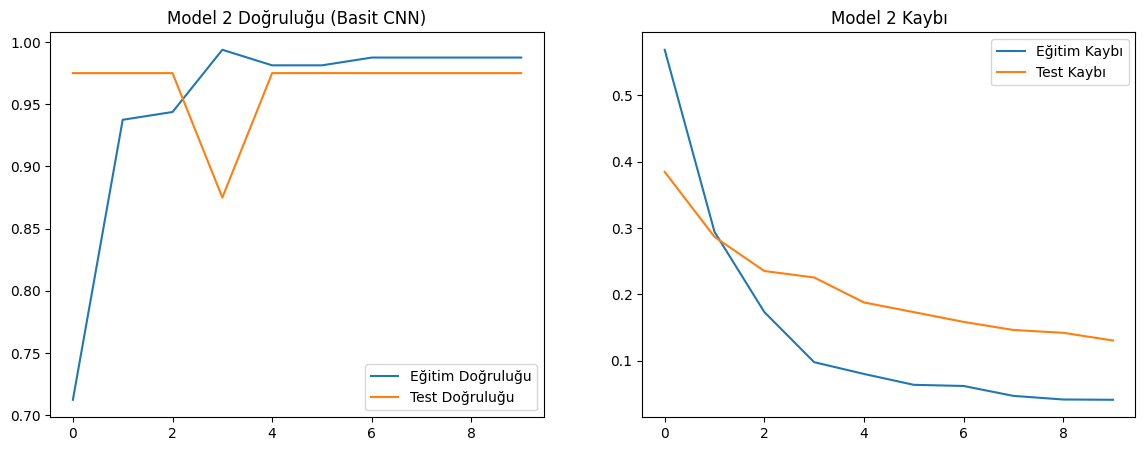

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9875 - loss: 0.1244

--------------------------------------
✅ Model 1 (Basit CNN) Test Seti Doğruluğu : %97.50
📉 Model 1 (Basit CNN) Test Seti Kaybı     : 0.1304
--------------------------------------


In [11]:
# Grafikler
plt.figure(figsize=(14, 5))

# Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Test Doğruluğu')
plt.title('Model 2 Doğruluğu (Basit CNN)')
plt.legend()

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Test Kaybı')
plt.title('Model 2 Kaybı')
plt.legend()

plt.show()

# Final Test Sonuçlarını Hesapla ve Yazdır
test_loss, test_acc = model.evaluate(validation_generator)

print(f"\n--------------------------------------")
print(f"✅ Model 1 (Basit CNN) Test Seti Doğruluğu : %{test_acc*100:.2f}")
print(f"📉 Model 1 (Basit CNN) Test Seti Kaybı     : {test_loss:.4f}")
print(f"--------------------------------------")